<small>

**Key differences from JAX implementation:**  
- <b>Network definition:</b> Use a Flax <code>nn.Module</code> (e.g., an <code>MLP</code> class) instead of lists of parameter dicts.  
- <b>Initialization:</b> Flax handles parameter initialization with <code>model.init(...)</code>, using specified initializers within the class.  
- <b>Forward pass:</b> Compute outputs with <code>model.apply(params, x)</code> instead of manual matrix multiplications.  

</small>

In [24]:
from typing import Sequence

import jax
import jax.numpy as jnp
import tensorflow_datasets as tfds
from flax import linen as nn
from flax.training import train_state
import optax
import orbax.checkpoint as ocp
from pathlib import Path


In [25]:
# Load MNIST from TensorFlow Datasets
data_dir = '/tmp/tfds' # data_dir = './data/tfds'
mnist_data, info = tfds.load(name="mnist", batch_size=-1, data_dir=data_dir, with_info=True)

In [26]:
def normalise(x, x_max=255.0):
    return x / x_max

def convert_to_jax(data_np, data_type):
    if data_type == "image":
        data_jax = normalise(jnp.array(data_np, dtype=jnp.float32))
    elif data_type == "label":
        data_jax = jnp.array(data_np)
    else:
        raise ValueError("not image or label")
    return data_jax

def flatten_image_for_mlp(data_jax):
    """Produces one greyscale vector per sample"""
    n_batch, n_pixels_vertical, n_pixels_horizontal, n_channels = data_jax.shape
    data_flattened = data_jax.reshape(n_batch, -1)
    return data_flattened

def prepare_data(data_dict: dict, subsample_size: int=0):
    data_jax = {}
    for data_type, data_tf in data_dict.items():
        data_numpy = data_tf.numpy()
        data = convert_to_jax(data_numpy, data_type)
        if data_type == "image":
            data = flatten_image_for_mlp(data)
        if subsample_size > 0:
            data = data[:subsample_size]
        data_jax[data_type] = data

    return data_jax

In [27]:
class MLP(nn.Module):
    layer_sizes: Sequence[int]

    @nn.compact
    def __call__(self, activations):
        for layer_number, layer_size in enumerate(self.layer_sizes):
            activations = nn.Dense(
                layer_size,
                kernel_init=nn.initializers.normal(0.1),
                bias_init=nn.initializers.normal(0.1)
            )(activations)

            if layer_number != (len(self.layer_sizes) - 1):
                activations = nn.relu(activations)

        return activations

In [28]:
class LowRankDense(nn.Module):
    """Low-rank dense layer implemented with two factors and einsum.

    Parameters are U in R^{in_features x rank} and V in R^{rank x features}.
    The forward pass computes y = (x @ U) @ V + b using einsum.
    """
    features: int
    rank: int
    use_bias: bool = True

    @nn.compact
    def __call__(self, inputs):
        # inputs: [batch, in_features]
        in_features = inputs.shape[-1]

        U = self.param(
            "U",
            nn.initializers.normal(0.1),
            (in_features, self.rank),
        )
        V = self.param(
            "V",
            nn.initializers.normal(0.1),
            (self.rank, self.features),
        )

        hidden = jnp.einsum("bi,ir->br", inputs, U)
        y = jnp.einsum("br,rf->bf", hidden, V)

        if self.use_bias:
            bias = self.param(
                "bias",
                nn.initializers.normal(0.1),
                (self.features,),
            )
            y = y + bias

        return y


class LowRankMLP(nn.Module):
    """
    Every layer uses the same low-rank dimension rank (="rank")
    """
    layer_sizes: Sequence[int]
    rank: int

    @nn.compact
    def __call__(self, activations):
        for layer_number, layer_size in enumerate(self.layer_sizes):
            activations = LowRankDense(
                features=layer_size,
                rank=self.rank,
                use_bias=True,
            )(activations)

            if layer_number != (len(self.layer_sizes) - 1):
                activations = nn.relu(activations)

        return activations


In [29]:
def initialise_network_params(model, input_layer_size, key):
    """Initialize all layers for a fully-connected neural network"""
    input_shape_dummy = jnp.ones((1, input_layer_size))
    params = model.init(key, input_shape_dummy)["params"]
    return params

In [30]:
def calculate_mean_loss_batch(params, apply_fn, images, labels):
    logits = apply_fn({"params": params}, images) # FORWARD PASS
    cross_entropy_by_sample = optax.softmax_cross_entropy_with_integer_labels(logits, labels)
    cross_entropy_mean = cross_entropy_by_sample.mean()
    return cross_entropy_mean

In [31]:
@jax.jit
def take_training_step(training_state, images, labels):
    """
    Single training step 
    The model and optimiser are passed in the training state
    returns a training state
    """
    grads_by_params_fn = jax.grad(calculate_mean_loss_batch)
    grads_by_params = grads_by_params_fn(
        training_state.params,     # params is first → grad w.r.t. params
        training_state.apply_fn,
        images,
        labels,
    )
    return training_state.apply_gradients(grads=grads_by_params)

In [32]:
def get_batches(images, labels, n_batches):
    """Drops the last set of samples if they're not the right length"""
    n_samples = len(images)
    assert len(images) == len(labels)
    assert n_samples >= n_batches
    assert n_batches > 0
    n_samples_per_batch = n_samples // n_batches
    start = 0
    end = n_samples_per_batch
    while end <= n_samples: 
        yield (images[start:end], labels[start:end])
        start += n_samples_per_batch
        end += n_samples_per_batch

In [33]:
def make_experiment_name(layer_sizes, optimizer):
    layer_part = "mlp_" + "-".join(str(s) for s in layer_sizes)
    opt_name = optimizer.__class__.__name__
    return f"{layer_part}_{opt_name}"

def initialise_checkpoint_manager(experiment_name: str = "mlp", max_to_keep=20):
    project_root = Path().resolve()
    base_dir = project_root / "checkpoints"
    checkpoint_dir = base_dir / experiment_name
    checkpoint_dir.mkdir(parents=True, exist_ok=True)
    checkpoint_manager = ocp.CheckpointManager(
        directory=str(checkpoint_dir),
        options=ocp.CheckpointManagerOptions(max_to_keep=max_to_keep),
    )
    return checkpoint_manager

In [34]:
def create_training_state(layer_sizes, optimizer, key, use_lowrank: bool = False, rank: int | None = None):
    input_layer_size = layer_sizes[0]
    network_layer_sizes = layer_sizes[1:]

    if use_lowrank:
        if rank is None:
            raise ValueError("rank must be provided when use_lowrank=True")
        model = LowRankMLP(layer_sizes=network_layer_sizes, rank=rank)
    else:
        model = MLP(layer_sizes=network_layer_sizes)

    apply_fn = model.apply
    params = initialise_network_params(model, input_layer_size, key)
    training_state = train_state.TrainState.create(
        apply_fn=apply_fn,
        params=params,
        tx=optimizer,
    )
    return training_state

In [35]:
def run_training(
    images,
    labels,
    n_steps,
    layer_sizes,
    optimizer,
    checkpoint_manager,
    key,
    steps_per_save,
    training_state,
    use_lowrank: bool = False,
    rank: int | None = None,
    ): 
    """
    The training state ('state') is an instance of TrainState that holds:
    - apply_fn: the model's apply function, used for forward passes
    - params: the parameters of the neural network
    - tx: the optimizers (Optax transformation) for parameter updates
    - opt_state: the state of the optimizer
    """
    if training_state is None:
        training_state = create_training_state(
            layer_sizes,
            optimizer,
            key,
            use_lowrank=use_lowrank,
            rank=rank,
        )

    for images_batch, labels_batch in get_batches(images=images, labels=labels, n_batches=n_steps):
        training_state = take_training_step(training_state, images_batch, labels_batch)
        step = training_state.step
        loss = calculate_mean_loss_batch(training_state.params, training_state.apply_fn, images_batch, labels_batch)
        print(f"step {step}: loss={loss}")
        if step == 1 or step % steps_per_save == 0:
            step_dir = step
            checkpoint_manager.save(
                step_dir,
                args=ocp.args.StandardSave(training_state)
                )

    return training_state.params

In [36]:
def train_mlp(
    train_data,
    optimizer,
    n_steps=10**3,
    steps_per_save=100,
    training_state=None,
    key=jax.random.key(0),
    use_lowrank: bool = False,
    rank: int | None = None,
    layer_sizes=(784, 128, 10),
):
    layer_sizes = list(layer_sizes)
    experiment_name = make_experiment_name(layer_sizes, optimizer)
    if use_lowrank:
        if rank is None:
            raise ValueError("rank must be provided when use_lowrank=True")
        experiment_name = experiment_name + f"_lowrank-r{rank}"

    checkpoint_manager = initialise_checkpoint_manager(experiment_name)
    final_params = run_training(
        images=train_data["image"],
        labels=train_data["label"],
        n_steps=n_steps,
        layer_sizes=layer_sizes,
        optimizer=optimizer,
        checkpoint_manager=checkpoint_manager,
        key=key,
        steps_per_save=steps_per_save,
        training_state=training_state,
        use_lowrank=use_lowrank,
        rank=rank,
    )
    return final_params

In [37]:
def extract_layer_sizes(params):
    layer_sizes = []
    for layer, layer_params in enumerate(params.values()):
        if layer == 0:
            layer_sizes.append(layer_params["kernel"].shape[0])
            layer_sizes.append(layer_params["kernel"].shape[1])
        else:
            layer_sizes.append(layer_params["bias"].shape[0])
    return layer_sizes

In [38]:
def evaluate_mlp(
    test_data,
    params,
    n_examples=10,
    use_lowrank: bool = False,
    rank: int | None = None,
    layer_sizes=None,
):
    images = test_data["image"]
    labels = test_data["label"]

    if use_lowrank:
        if layer_sizes is None:
            raise ValueError("layer_sizes must be provided when use_lowrank=True")
        if rank is None:
            raise ValueError("rank must be provided when use_lowrank=True")
        model = LowRankMLP(layer_sizes=layer_sizes[1:], rank=rank)
    else:
        layer_sizes = extract_layer_sizes(params)
        model = MLP(layer_sizes=layer_sizes[1:])

    apply_fn = model.apply

    mean_loss = calculate_mean_loss_batch(params, apply_fn, images, labels)
    example_images = images[:n_examples]
    example_labels = labels[:n_examples]
    logits = apply_fn({"params": params}, example_images)
    example_predictions = jnp.argmax(logits, axis=1)

    prefix = "[low-rank] " if use_lowrank else ""
    print(prefix + "Mean loss       ", mean_loss)
    print(prefix + "True labels:    ", example_labels)
    print(prefix + "Predictions:    ", example_predictions)

1. Learning rate decay
2. Weight decay

In [39]:
train_data = prepare_data(mnist_data["train"], subsample_size=10**3) 
test_data = prepare_data(mnist_data["test"], subsample_size=10**3) 

In [40]:
learning_rate = 1e-3
optimizer = optax.adam(learning_rate)
params = train_mlp(train_data, optimizer)
evaluate_mlp(test_data, params)

step 1: loss=2.2421865463256836
step 2: loss=1.4549815654754639
step 3: loss=3.0767364501953125
step 4: loss=1.6018767356872559
step 5: loss=1.9223350286483765
step 6: loss=1.551820993423462
step 7: loss=2.2047572135925293
step 8: loss=2.283871650695801
step 9: loss=1.3409205675125122
step 10: loss=2.344090700149536
step 11: loss=2.6371212005615234
step 12: loss=3.4621238708496094
step 13: loss=1.713283658027649
step 14: loss=1.9781702756881714
step 15: loss=3.341600179672241
step 16: loss=2.9397130012512207
step 17: loss=1.0316028594970703
step 18: loss=2.92775821685791
step 19: loss=2.7445106506347656
step 20: loss=1.4158217906951904
step 21: loss=1.9610297679901123
step 22: loss=1.998666524887085
step 23: loss=1.672989845275879
step 24: loss=2.457414150238037
step 25: loss=1.5557224750518799
step 26: loss=2.3051018714904785
step 27: loss=2.603789806365967
step 28: loss=1.988590955734253
step 29: loss=2.3711462020874023
step 30: loss=1.6227277517318726
step 31: loss=1.862285733222961

GANs

In [41]:
def cross_entropy_loss_single_label(logits, label):
    targets = jnp.full_like(logits, label)
    return optax.sigmoid_binary_cross_entropy(logits, targets).mean()

def generator_loss(pfake_logits_given_fake):
    """Label=0 because the generator is trying to make fake images look real (low p(fake))."""
    return cross_entropy_loss_single_label(logits=pfake_logits_given_fake, label=0)

def discriminator_loss(pfake_logits_given_real, pfake_logits_given_fake):
    logits_given_real = cross_entropy_loss_single_label(logits=pfake_logits_given_real, label=0)
    logits_given_fake = cross_entropy_loss_single_label(logits=pfake_logits_given_fake, label=1)
    return (logits_given_real + logits_given_fake) / 2

In [42]:
def calculate_generator_loss(generator_params, discriminator_params, generator_apply_fn, discriminator_apply_fn, z_vector):
    fake_images = generator_apply_fn({"params": generator_params}, z_vector)
    pfake_logits_given_fake = discriminator_apply_fn({"params": discriminator_params}, fake_images)
    return generator_loss(pfake_logits_given_fake)


def calculate_discriminator_loss(discriminator_params, generator_params, generator_apply_fn, discriminator_apply_fn, z_vector, real_images):
    fake_images = generator_apply_fn({"params": generator_params}, z_vector)
    pfake_logits_given_fake = discriminator_apply_fn({"params": discriminator_params}, fake_images)
    pfake_logits_given_real = discriminator_apply_fn({"params": discriminator_params}, real_images)
    return discriminator_loss(pfake_logits_given_real, pfake_logits_given_fake)

In [43]:
@jax.jit
def take_generator_step(generator, discriminator, z_vector):
    grads_by_params_fn = jax.grad(calculate_generator_loss)
    grads_by_params = grads_by_params_fn(
        generator.params,
        discriminator.params,
        generator.apply_fn,
        discriminator.apply_fn,
        z_vector,
    )
    return generator.apply_gradients(grads=grads_by_params)


@jax.jit
def take_discriminator_step(generator, discriminator, z_vector, real_images):
    grads_by_params_fn = jax.grad(calculate_discriminator_loss)
    grads_by_params = grads_by_params_fn(
        discriminator.params,
        generator.params,
        generator.apply_fn,
        discriminator.apply_fn,
        z_vector,
        real_images,
    )
    return discriminator.apply_gradients(grads=grads_by_params)

In [44]:
def run_training_gan(
    train_data,
    n_steps,
    generator_training_state,
    discriminator_training_state,
    key,
    steps_per_save,
    checkpoint_manager,
):
    real_images = train_data["image"]

    for step in range(1, n_steps + 1):
        key, key_z_current_step = jax.random.split(key)
        z_vectors = jax.random.normal(key_z_current_step, real_images.shape)

        discriminator_training_state = take_discriminator_step(
            generator_training_state,
            discriminator_training_state,
            z_vectors,
            real_images,
        )
        generator_training_state = take_generator_step(
            generator_training_state,
            discriminator_training_state,
            z_vectors,
        )

        generator_loss_value = calculate_generator_loss(
            generator_training_state.params,
            discriminator_training_state.params,
            generator_training_state.apply_fn,
            discriminator_training_state.apply_fn,
            z_vectors,
        )
        discriminator_loss_value = calculate_discriminator_loss(
            discriminator_training_state.params,
            generator_training_state.params,
            generator_training_state.apply_fn,
            discriminator_training_state.apply_fn,
            z_vectors,
            real_images,
        )
        print(f"step {step}: generator_loss={generator_loss_value}, discriminator_loss={discriminator_loss_value}")

        if step == 1 or step % steps_per_save == 0:
            checkpoint_manager.save(
                step,
                args=ocp.args.StandardSave(
                    {
                        "generator": generator_training_state,
                        "discriminator": discriminator_training_state,
                    }
                ),
            )

    return generator_training_state, discriminator_training_state, key

In [45]:
def setup_gan_training(optimizer, key=jax.random.key(0)):
    N_PIXELS = 784
    N_HIDDEN_LAYER = 128
    N_BINARY_CATEGORIES = 1

    layer_sizes_generator = [N_PIXELS, N_HIDDEN_LAYER, N_PIXELS]
    layer_sizes_discriminator = [N_PIXELS, N_HIDDEN_LAYER, N_BINARY_CATEGORIES]

    g_key, d_key = jax.random.split(key)
    generator_training_state = create_training_state(layer_sizes_generator, optimizer, g_key)
    discriminator_training_state = create_training_state(layer_sizes_discriminator, optimizer, d_key)
    return generator_training_state, discriminator_training_state, key

In [46]:
def train_gan(
    train_data, 
    optimizer, 
    n_steps=10**3, 
    steps_per_save=100, 
    key=jax.random.key(0),
    ):
    experiment_name = f"gan_{optimizer.__class__.__name__}"
    checkpoint_manager = initialise_checkpoint_manager(experiment_name)

    generator_training_state, discriminator_training_state, key = setup_gan_training(
        optimizer=optimizer,
        key=key,
    )

    generator_training_state, discriminator_training_state, key = run_training_gan(
        train_data=train_data,
        n_steps=n_steps,
        generator_training_state=generator_training_state,
        discriminator_training_state=discriminator_training_state,
        key=key,
        steps_per_save=steps_per_save,
        checkpoint_manager=checkpoint_manager,
    )
    return generator_training_state, discriminator_training_state, key

In [47]:
generator_training_state, discriminator_training_state, key = train_gan(
    train_data,
    optimizer,
    n_steps=1000,
    key=jax.random.key(0),
)

step 1: generator_loss=2.6123626232147217, discriminator_loss=0.8546755909919739
step 2: generator_loss=1.774949312210083, discriminator_loss=0.9896562695503235
step 3: generator_loss=1.076843500137329, discriminator_loss=1.2804691791534424
step 4: generator_loss=0.7178224325180054, discriminator_loss=1.5891304016113281
step 5: generator_loss=0.4751269221305847, discriminator_loss=1.9167433977127075
step 6: generator_loss=0.3422739803791046, discriminator_loss=2.1171340942382812
step 7: generator_loss=0.31401827931404114, discriminator_loss=2.3400914669036865
step 8: generator_loss=0.3016282916069031, discriminator_loss=2.330327033996582
step 9: generator_loss=0.30341944098472595, discriminator_loss=2.3457579612731934
step 10: generator_loss=0.33698737621307373, discriminator_loss=2.246582508087158
step 11: generator_loss=0.5274619460105896, discriminator_loss=1.9459904432296753
step 12: generator_loss=0.6122791767120361, discriminator_loss=1.828513264656067
step 13: generator_loss=0.7

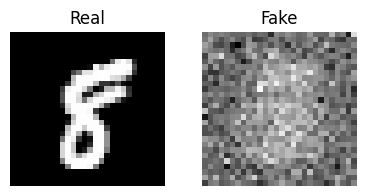

In [50]:
import matplotlib.pyplot as plt

# Sample latent vector and a real image index
key, z_key, real_key = jax.random.split(key, 3)
z_vector = jax.random.normal(z_key, (1, train_data["image"].shape[1]))
real_idx = jax.random.randint(real_key, shape=(), minval=0, maxval=train_data["image"].shape[0])

# Generate fake image
fake_image_flat = generator_training_state.apply_fn(
    {"params": generator_training_state.params},
    z_vector,
)
fake_image = fake_image_flat[0].reshape(28, 28)

# Select corresponding real image
real_image_flat = train_data["image"][real_idx]
real_image = real_image_flat.reshape(28, 28)

# Plot real vs fake side by side
fig, axes = plt.subplots(1, 2, figsize=(4, 2))
axes[0].imshow(real_image, cmap="gray")
axes[0].set_title("Real")
axes[0].axis("off")

axes[1].imshow(fake_image, cmap="gray")
axes[1].set_title("Fake")
axes[1].axis("off")

plt.tight_layout()
plt.show()
